In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy.stats as sst
import matplotlib.pyplot as plt
import os
import os.path as osp
from __future__ import print_function
from __future__ import division
import six
import cnv_util as util
reload(util)

<module 'cnv_util' from 'cnv_util.pyc'>

## Reading TSV files 

In [3]:
CWD = osp.join(osp.expanduser('~'), 'documents','grants_projects','roberto_projects', \
               'guillaume_huguet_CNV','File_OK')
filename = 'Imagen_QC_CIA_MMAP_V2_Annotation.tsv'
fullfname = osp.join(CWD, filename)

In [4]:
arr = np.loadtxt(fullfname, dtype='str', comments=None, delimiter='\Tab', 
                 converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)

In [5]:
EXPECTED_LINES = 19542
expected_nb_values = EXPECTED_LINES - 1 
assert arr.shape[0] == EXPECTED_LINES
line0 = arr[0].split('\t')
print(line0)

danger = 'Pvalue_MMAP_V2_sans_intron_and_Intergenic'
score = 'SCORE'
i_danger = line0.index(danger)
i_score = line0.index(score)
print(i_danger, i_score)

['IID_projet', 'IID_genotype', 'SampleID', 'CHR de Merge_CIA_610_660_QC', 'START', 'STOP', 'TYPE de Merge_CIA_610_660_QC', 'SCORE', 'ConcatSNP', 'Gene', 'Location', '#Genes', '#Exons', "5'gene", "5'dist(kb)", "3'gene", "3'dist(kb)", 'dups(DGV)', 'dels(DGV)', 'total_known_CNVs(DGV)', 'num_papers(DGV)', 'papers', 'hg18_DGV_1%_Mar2010.txt %overlap', 'hg18_Chromosome_band.txt', 'hg18_segdups.txt %overlap', 'hg18_genome_features.txt', 'hg18_genome_features.txt %overlap', 'Pvalue_MMAP_V2_sans_intron_and_Intergenic']
27 7


In [6]:
# check that all lines have the same number of tab separated elements 
larr =  np.asarray([len(arr[i].split('\t')) for i in range(arr.shape[0])])
assert not (larr - larr[0]).any() # all element have the same value 

In [7]:
dangers = np.asarray([line.split('\t')[i_danger] for line in arr[1:]])
scores = np.asarray([line.split('\t')[i_score] for line in arr[1:]])
# print(np.unique(scores))

assert len(dangers) == expected_nb_values
assert len(scores) == expected_nb_values

## transforming the "Pvalue_MMAP_V2_..." into danger score

### Testing the function danger_score

In [8]:
assert  util._test_danger_score_1()
assert  util._test_danger_score()

__ QUESTION pour Guillaume: __
a quoi correspondent les '' dans la colonne "Pvalue_MMAP_V2_sans_intron_and_Intergenic" (danger)?

Ansewer: cnv for which we have no dangerosity information

In [9]:
"""
danger_not_empty = dangers != ''
danger_scores = dangers[danger_not_empty]
danger_scores = np.asarray([util.danger_score(pstr, util.pH1_with_apriori) 
                                                    for pstr in danger_scores])
""";

## To be or not to be a CNV: p value from the 'SCORE' column 

In [10]:
#get the scores
scores = np.asarray([line.split('\t')[i_score] for line in arr[1:]])
assert len(scores) == expected_nb_values
print(len(np.unique(scores)))
tmp = np.asarray([util.str2floats(s, comma2point=True, sep=' ')[0] for s in scores])
assert tmp.shape[0] == EXPECTED_LINES - 1 


14903


In [11]:
# h = plt.hist(tmp[tmp > sst.scoreatpercentile(tmp, 99)], bins=100)
# h = plt.hist(tmp[tmp < 50], bins=100)

"""
print("# CNV with score == 0.: ", (tmp==0.).sum())
print("# CNV with score >=15 < 17.5 : ", np.logical_and(tmp >= 15., tmp < 17.5).sum())
tmp.max()
""";

## Replace the zero score by the maximum score: cf Guillaume's procedure

In [12]:
# if the score is zero, put it to maximum value : it means the CNV has a maximum score
clean_score = tmp
clean_score[tmp==0.] = tmp.max()
# h = plt.hist(tmp[tmp < 60], bins=100)

## Transforms the scores into P(cnv is real)

In [23]:
reload(util)
# Creating a function from score to proba from Guillaume's values
p_cnv = util._build_dict_prob_cnv()
#print(p_cnv.keys())
#print(p_cnv.values())

#### Definition with a piecewise linear function
score2prob = util.create_score2prob_lin_piecewise(p_cnv)
#scores = np.arange(15,50,1)
#probs = [score2prob(sc) for sc in scores]
#plt.plot(scores, probs)

#### Definition with a corrected regression line
score2prob = util.create_score2prob_lin(p_cnv)
#x = np.arange(0,50,1)
#plt.plot(x, [score2prob(_) for _ in x], '-', p_cnv.keys(), p_cnv.values(), '+')

In [24]:
p_scores = [score2prob(sc) for sc in clean_score]
assert len(p_scores) == EXPECTED_LINES -1 

## Finally, putting things together 

In [32]:
# re-loading 
CWD = osp.join(osp.expanduser('~'), 'documents','grants_projects','roberto_projects', \
               'guillaume_huguet_CNV','File_OK')
filename = 'Imagen_QC_CIA_MMAP_V2_Annotation.tsv'
fullfname = osp.join(CWD, filename)

# in numpy array
arr = np.loadtxt(fullfname, dtype='str', comments=None, delimiter='\Tab', 
                 converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)

line0 = arr[0].split('\t')
DANGER = 'Pvalue_MMAP_V2_sans_intron_and_Intergenic'
SCORE = 'SCORE'

i_DANGER = line0.index(DANGER)
i_SCORE = line0.index(SCORE)
i_START = line0.index('START')
i_STOP = line0.index('STOP')
i_5pGENE = line0.index("5'gene")
i_3pGENE = line0.index("3'gene")
i_5pDIST = line0.index("5'dist(kb)")
i_3pDIST = line0.index("3'dist(kb)")
#i_LOC = line0.index('Location')

for idx in range(len(line0)):
    print(line0[idx],': ', arr[1].split('\t')[idx])

IID_projet :  000067227272
IID_genotype :  67227272
SampleID :  67227272-660Wq
CHR de Merge_CIA_610_660_QC :  2
START :  41092148
STOP :  41109046
TYPE de Merge_CIA_610_660_QC :  1
SCORE :  22,895
ConcatSNP :  10
Gene :  0
Location :  Intergenic
#Genes :  0
#Exons :  0
5'gene :  SLC8A1
5'dist(kb) :  499,069
3'gene :  SGK493
3'dist(kb) :  1019.618
dups(DGV) :  13
dels(DGV) :  832
total_known_CNVs(DGV) :  845
num_papers(DGV) :  13
papers :  Altshuler et al. (2010), Conrad et al. (2005), Conrad et al. (2009), Itsara et al. (2009), Jakobsson et al. (2008), Matsuzaki et al. (2009), McCarroll et al. (2005), McCarroll et al. (2008), Park et al. (2010), Perry et al. (2008), Shaikh et al. (2009), Wang et al. (2007), de Smith et al. (2007)
hg18_DGV_1%_Mar2010.txt %overlap :  73%
hg18_Chromosome_band.txt :  2p22.1
hg18_segdups.txt %overlap :  0%
hg18_genome_features.txt :  0
hg18_genome_features.txt %overlap :  0%
Pvalue_MMAP_V2_sans_intron_and_Intergenic :  


In [33]:
# A function to create unique identifiers of subj, CNV, etc

def cnv_uiid(tsv_arr, columns_names, first_line=None):
    """
    columns_names: list of column names with which the uiid are constructed
    returns a list if given the full array, 
    returns a string if given only one line (and the first line)
    """
    
    chr2rm = ''.join([',', '.', ' ']) # others: ['!', '?', ...] ?
    
    if isinstance(tsv_arr, six.string_types) and (first_line != None):
        # assume we are given one line of the tsv array
        indexes = [first_line.split('\t').index(colname) for colname in columns_names]
        uiid = '_'.join([(tsv_arr.split('\t')[ind]).translate(None,chr2rm) for ind in indexes])
        
    else: 
        uiid = []
        indexes = [tsv_arr[0].split('\t').index(colname) for colname in columns_names]
        for line in tsv_arr[1:]:
            ll = line.split('\t')
            uiid.append('_'.join([ll[ind] for ind in indexes]))

    return uiid

In [35]:
print(line0)

['IID_projet', 'IID_genotype', 'SampleID', 'CHR de Merge_CIA_610_660_QC', 'START', 'STOP', 'TYPE de Merge_CIA_610_660_QC', 'SCORE', 'ConcatSNP', 'Gene', 'Location', '#Genes', '#Exons', "5'gene", "5'dist(kb)", "3'gene", "3'dist(kb)", 'dups(DGV)', 'dels(DGV)', 'total_known_CNVs(DGV)', 'num_papers(DGV)', 'papers', 'hg18_DGV_1%_Mar2010.txt %overlap', 'hg18_Chromosome_band.txt', 'hg18_segdups.txt %overlap', 'hg18_genome_features.txt', 'hg18_genome_features.txt %overlap', 'Pvalue_MMAP_V2_sans_intron_and_Intergenic']


In [38]:
#names_from = ['START', 'STOP', "5'gene", "3'gene", "5'dist(kb)", "3'dist(kb)"]

#---------- ligne uniques:
names_from = ['IID_projet', 'IID_genotype', "CHR de Merge_CIA_610_660_QC", 'START', 'STOP'] 
cnv_names = cnv_uiid(arr, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))

#---------- CNV uniques ? 
names_from = ["CHR de Merge_CIA_610_660_QC", 'START', 'STOP'] 
cnv_names = cnv_uiid(arr, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))

#---------- CNV uniques ? 
"""
names_from = ['START', 'STOP', "5'gene", "3'gene", "5'dist(kb)", "3'dist(kb)"]
cnv_names = cnv_uiid(arr, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))
"""

#---------- sujets uniques ? 
names_from = ['IID_projet'] # , 'IID_genotype'] 
cnv_names = cnv_uiid(arr, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))

dangers = np.asarray([line.split('\t')[i_DANGER] for line in arr[1:]])
scores = np.asarray([line.split('\t')[i_SCORE] for line in arr[1:]])

#danger_not_empty = dangers != ''
#print(danger_not_empty.sum())
#print(len(np.unique(cnv_name)))
#print(cnv_name[:10])

with names from:  ['IID_projet', 'IID_genotype', 'CHR de Merge_CIA_610_660_QC', 'START', 'STOP']
we have 19541 unique elements out of 19541 rows in the tsv
with names from:  ['CHR de Merge_CIA_610_660_QC', 'START', 'STOP']
we have 7337 unique elements out of 19541 rows in the tsv
with names from:  ['IID_projet']
we have 1712 unique elements out of 19541 rows in the tsv


### Create a dict of the cnv

In [39]:
#gene_name_set = set([line.split('\t')[i_3pGENE] for line in arr[1:]]) | \
#           set([line.split('\t')[i_5pGENE] for line in arr[1:]])
#print('len(gene_name_set): ', len(gene_name_set))

# this creates an dict where the keys are unique indentifiers of cnv, values 
# are (dangerosity, probability_cnv)

cnv = OrderedDict({})
names_from = ["CHR de Merge_CIA_610_660_QC", 'START', 'STOP']  #, "5'gene", "3'gene", "5'dist(kb)", "3'dist(kb)"]
blank_dgr = 0

for line in arr[1:]:
    lline = line.split('\t')
    dgr = lline[i_DANGER]
    scr  = lline[i_SCORE]
    cnv_iid = cnv_uiid(line, names_from, arr[0])
    
    if dgr != '':
        add_cnv = (danger_score(lline[i_DANGER], pH1_with_apriori),
                   score2prob(lline[i_SCORE]))
        if cnv_iid in cnv.keys():
            cnv[cnv_iid].append(add_cnv)
        else:
            cnv[cnv_iid] = [add_cnv]
    else:
        blank_dgr += 1


In [40]:
print(len(cnv), (blank_dgr))
print([k for k in cnv.keys()[:5]])

3374 12294
['10_134903403_134996704', '18_2578360_2611407', '17_17683629_17693534', '18_2576907_2611407', '17_17651995_17693534']


In [41]:
names_from = ["CHR de Merge_CIA_610_660_QC", 'START', 'STOP'] 
cnv_names = cnv_uiid(arr, names_from)
print("with names from: ", names_from)
print("we have {} unique elements out of {} rows in the tsv".format(
                                len(np.unique(cnv_names)), len(cnv_names)))
#print(cnv_names[:5])

# To be check : the 7337 unique cnv should reduce to 3374 when we remove those for which dgr == ''


with names from:  ['CHR de Merge_CIA_610_660_QC', 'START', 'STOP']
we have 7337 unique elements out of 19541 rows in the tsv


In [42]:
__kcnv = cnv.keys()
print(len(__kcnv))
for _ in __kcnv[3330:3350]:
    print(_,': ',cnv[_])

3374
1_995669_1011521 :  [(0.99999999999999312, 1.0)]
22_19339596_19429297 :  [(3.0, 1.0), (3.0, 1.0), (3.0, 1.0)]
22_19339596_19424781 :  [(3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0), (3.0, 1.0)]
22_19343347_19429297 :  [(3.0, 1.0)]
22_19345218_19424781 :  [(3.0, 1.0)]
22_18328337_18337023 :  [(1.0, 1.0), (1.0, 1.0), (1.0, 1.0)]
22_18330428_18337023 :  [(1.0, 1.0)]
22_18328337_18358558 :  [(2.0, 1.0)]
22_18336781_18400229 :  [(3.0, 1.0)]
2_110243431_110339819 :  [(1.9999998829812593, 1.0), (1.9999998829812593, 1.0), (1.9999998829812593, 1.0)]
21_14830513_14852044 :  [(0.99999999999989209, 1.0), (0.99999999999989209, 1.0), (0.99999999999989209, 1.0)]
11_127888014_127946707 :  [(0.99999999999999989, 1.0)]
7_73481452_73512817 :  [(0.99999999999998568, 1.0)]
22_48960865_49003996 :  [(2.9999999979009999, 1.0)]
22_48951780_48979320 :  [(1.9999999996940001, 1.0)]
22_48951780_49000551 :  [(3.999999997748000

In [43]:
#for k in cnv.keys():
#    if len(cnv[k]) > 1:
#        if len(set([cnv[k][i][0] for i in range(len(cnv[k]))])) > 1:
#            pass
#            # print(cnv[k])
#        #print([t[0] for t in cnv[k]])

### Create a dictionary of the subjects - 

In [44]:
#print(len(arr), line0)

In [45]:
cnv = OrderedDict({})
#names_from = ['START', 'STOP', "5'gene", "3'gene", "5'dist(kb)", "3'dist(kb)"]
names_from = ['IID_projet']

for line in arr[1:]:
    lline = line.split('\t')
    dgr = lline[i_DANGER]
    scr  = lline[i_SCORE]
    sub_iid = cnv_uiid(line, names_from, arr[0])
    
    if dgr != '':
        add_cnv = (danger_score(lline[i_DANGER], pH1_with_apriori),
                   score2prob(lline[i_SCORE]))
        if sub_iid in cnv.keys():
            cnv[sub_iid].append(add_cnv)
        else:
            cnv[sub_iid] = [add_cnv]

#### Histogram of the number of cnv used to compute dangerosity

1656
59


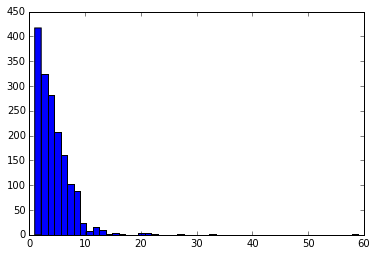

In [46]:
print(len(cnv))
nbcnv = [len(cnv[sb]) for sb in cnv]
hist = plt.hist(nbcnv, bins=50)
print(np.max(np.asarray(nbcnv)))

In [47]:
# definition of dangerosity from a list of cnv
def dangerosity(listofcnvs):
    """
    inputs: list tuples (danger_score, proba_cnv)
    returns: a dangerosity score 
    """
    last = -1 #slicing the last
    tmp = [np.asarray(t) for t in zip(*listofcnvs)]
    return tmp[0].dot(tmp[1])

# or: return np.asarray([dgr*prob for (dgr,prob) in listofcnvs]).cumsum()[last]


### Testing dangerosity

In [48]:
for k in range(1,30, 30):
    print(cnv[cnv.keys()[k]], ' yields ', dangerosity(cnv[cnv.keys()[k]]))
    
test_dangerosity_input = [[(1., .5), (1., .5), (1., .5), (1., .5)],
                          [(2., 1.)],
                          [(10000., 0.)]]
test_dangerosity_output = [2., 2., 0]

#print( [dangerosity(icnv) for icnv in test_dangerosity_input]) # == test_dangerosity_output
assert( [dangerosity(icnv) for icnv in test_dangerosity_input] == test_dangerosity_output)

[(0.99999942000033648, 1.0), (0.48377137638161954, 1.0), (0.49999999999999989, 1.0), (1.1666666666666665, 1.0)]  yields  3.15043746305


### Printing out results

In [49]:
outfile = 'dangerosity_cnv.txt'
fulloutfile = osp.join(CWD, outfile)

with open(fulloutfile, 'w') as outf:
    for sub in cnv:
        outf.write("\t".join([sub, str(dangerosity(cnv[sub]))]) + "\n")